In [1]:
import astropy.units as u
import astropy.coordinates as coord
import matplotlib.pyplot as plt
import numpy as np
import gala.dynamics as gd
import gala.potential as gp
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from scipy.optimize import minimize_scalar
from matplotlib.patches import Ellipse
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2

Helper Functions

In [2]:
def sample(dict, ics, n_samples=100):
    ra_samples = np.random.normal(dict['ra'], dict['e_ra'], n_samples)
    dec_samples = np.random.normal(dict['dec'], dict['e_dec'], n_samples)
    dist_samples = np.random.normal(dict['dist'], dict['e_dist'], n_samples)
    pmra_samples = np.random.normal(dict['pmra'], dict['e_pmra'], n_samples)
    pmdec_samples = np.random.normal(dict['pmdec'], dict['e_pmdec'], n_samples)
    rv_samples = np.random.normal(dict['rv'], dict['e_rv'], n_samples)

    ics_list = []
    ics_list.append(ics)
    for ra, dec, dist, pmra, pmdec, rv in zip(ra_samples, dec_samples, dist_samples, pmra_samples, pmdec_samples, rv_samples):
        sc = coord.SkyCoord(ra=ra * u.degree,
                    dec=dec * u.degree,
                    distance=dist * u.kpc,
                    pm_ra_cosdec=pmra * (u.mas / u.yr),
                    pm_dec=pmdec * (u.mas / u.yr),
                    radial_velocity=rv * (u.km / u.s),
                    frame="icrs")
        gc = sc.transform_to(coord.Galactocentric)
        ics = gd.PhaseSpacePosition(pos=gc.cartesian.xyz, vel=gc.velocity.d_xyz)
        ics_list.append(ics)
    
    return ics_list

def calculate_orbits(dict, ics, num_steps):
    ics_list = sample(dict, ics)

    orbits = []
    for ics in ics_list:
        orbit = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=num_steps)
        orbits.append(orbit)

    return orbits

def plot_ellipse(x_vals, y_vals, plane="XY", x2=None, y2=None):
    pos = np.column_stack((x_vals, y_vals))
    mean = np.mean(pos, axis=0)
    cov = np.cov(pos, rowvar=False)

    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

    fig, ax = plt.subplots(figsize=(4, 3))
    ax.scatter(x_vals, y_vals, s=3, color='red', alpha=0.5)
    if x2 is not None and y2 is not None:
        ax.scatter(x2, y2, s=3, color='black', alpha=0.5)

    # Confidence levels: 1σ (68%), 2σ (95%), 3σ (99.7%)
    for nsig in [1, 2, 3]:
        width, height = 2 * nsig * np.sqrt(eigvals)
        ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle,
                          edgecolor='blue', fc='None', lw=2, label=f"{nsig}σ")
        ax.add_patch(ellipse)

    ax.set_xlabel(f"{plane[0]} [kpc]")
    ax.set_ylabel(f"{plane[1]} [kpc]")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

def distance_mw(num_steps, ics):
    orbit = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=num_steps)
    final_z = orbit[-1].pos.xyz.to(u.kpc).value[2]
    return abs(final_z)

def plot_closest(dict, ics, function, mw=False, target=[0,0,0], dwarf_points=None):
    ics_list = sample(dict, ics, 1000)

    k=3

    points = []
    times = []
    for ics in ics_list:
        result = minimize_scalar(
            function,
            args=(ics,),
            bounds=(0, 8000),  # search between 0 and 8000 steps (800 Myr)
            method='bounded'
        )
        orbit = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=int(result.x))
        times.append(int(result.x)*0.1)
        final_pos = orbit[-1].pos.xyz.to(u.kpc).value[:k]
        points.append(final_pos)

    points = np.array(points)

    if mw==True:
        x = points[:, 0]
        y = points[:, 1]

        plot_ellipse(x, y)
    else:
        x = points[:, 0]
        y = points[:, 1]
        z = points[:, 2]

        if dwarf_points is not None:
            xd = dwarf_points[:, 0]
            yd = dwarf_points[:, 1]
            zd = dwarf_points[:, 2]

            plot_ellipse(x, y, "XY", xd, yd)
            plot_ellipse(x, z, "XZ", xd, zd)
            plot_ellipse(y, z, "YZ", yd, zd)
        else:
            plot_ellipse(x, y, "XY")
            plot_ellipse(x, z, "XZ")
            plot_ellipse(y, z, "YZ")

    # mahalanobis distance
    target = np.array(target)
    mean = np.mean(points, axis=0)
    cov = np.cov(points, rowvar=False)
    inv_cov = np.linalg.inv(cov)

    mahal_dist = mahalanobis(target, mean, inv_cov)
    
    p_value = 1 - chi2.cdf(mahal_dist**2, df=k)

    return p_value, times

First, define a gravitational potential.

In [3]:
pot = gp.MilkyWayPotential()

Ursa Major II

In [4]:
dwarf_dict = {
    'ra': 132.875, #degree
    'e_ra': 0.01, #degree
    'dec': 63.13, #degree
    'e_dec': 0.01, #degree
    'dist': 34.7, #kpc
    'e_dist': 1.95, #kpc
    'pmra': 1.72, #mas/yr
    'e_pmra': 0.02, #mas/yr
    'pmdec': -1.89, #mas/yr
    'e_pmdec': 0.03, #mas/yr
    'rv': -116.5, #km/s
    'e_rv': 1.9, #km/s
    }
dwarf = coord.SkyCoord(
    ra=dwarf_dict['ra'] * u.degree,
    dec=dwarf_dict['dec'] * u.degree,
    distance=dwarf_dict['dist'] * u.kpc,
    pm_ra_cosdec=dwarf_dict['pmra'] * (u.mas / u.yr),
    pm_dec=dwarf_dict['pmdec'] * (u.mas / u.yr),
    radial_velocity=dwarf_dict['rv'] * (u.km / u.s),
    frame="icrs"
)
dwarf_GC = dwarf.transform_to(coord.Galactocentric)
dwarf_ics = gd.PhaseSpacePosition(pos=dwarf_GC.cartesian.xyz, vel=dwarf_GC.velocity.d_xyz)

        Use name instead. [gala.dynamics.core]


HVS 14

In [5]:
dict = {
    'name': 'hvs14',
    'ra': 161.0072805184, #degree
    'e_ra': 0.0001, #degree
    'dec': 6.1941762509, #degree
    'e_dec': 0.0001, #degree
    'dist': 102.66, #kpc
    'e_dist': 16.55, #kpc
    'pmra': -2.17, #mas/yr
    'e_pmra': 1.38, #mas/yr
    'pmdec': 2.28, #mas/yr
    'e_pmdec': 1.68, #mas/yr
    'rv': 537.30, #km/s
    'e_rv': 7.20, #km/s
    }
hvs = coord.SkyCoord(
    ra=dict['ra'] * u.degree,
    dec=dict['dec'] * u.degree,
    distance=dict['dist'] * u.kpc,
    pm_ra_cosdec=dict['pmra'] * (u.mas / u.yr),
    pm_dec=dict['pmdec'] * (u.mas / u.yr),
    radial_velocity=dict['rv'] * (u.km / u.s),
    frame="icrs"
)
hvs_GC = hvs.transform_to(coord.Galactocentric)
hvs_ics = gd.PhaseSpacePosition(pos=hvs_GC.cartesian.xyz, vel=hvs_GC.velocity.d_xyz)

Milky Way Plot (z=0)

In [6]:
# p_value, times = plot_closest(dict, hvs_ics, distance_mw, mw=True)
# print(f"p_value: {p_value}")

Galaxy Plot

mean: [-35.89856379  14.75256605  16.6901923 ]


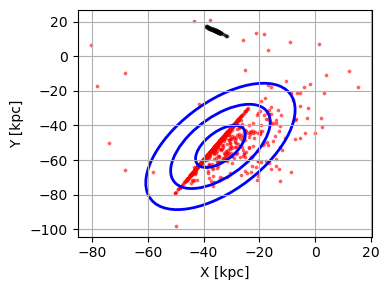

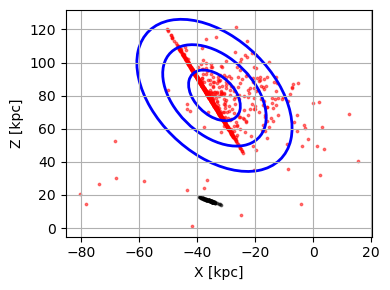

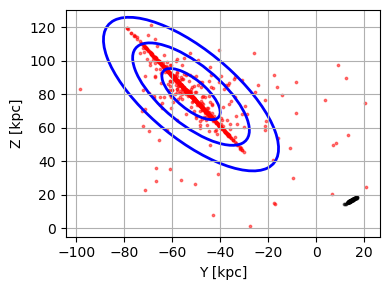

p_value: 2.3662594106355073e-10


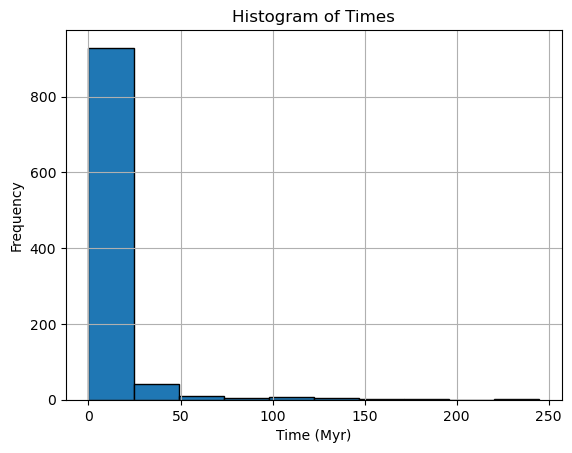

In [7]:
min = 200

dwarf_orbits = calculate_orbits(dwarf_dict, dwarf_ics, min)
dwarf_points = []
for orbit in dwarf_orbits:
    final_pos = orbit[-1].pos.xyz.to(u.kpc).value[:3]
    dwarf_points.append(final_pos)
dwarf_points = np.array(dwarf_points)
mean = np.mean(dwarf_points, axis=0)

print(f"mean: {mean}")

def distance_dwarf(num_steps, ics):
    orbit = pot.integrate_orbit(ics, dt=-0.1*u.Myr, n_steps=num_steps)
    final_pos = orbit[-1].pos.xyz.to(u.kpc).value[:3]
    distance = np.linalg.norm(final_pos - mean)
    return distance

p_value, times = plot_closest(dict, hvs_ics, distance_dwarf, target=mean, dwarf_points=dwarf_points)
print(f"p_value: {p_value}")

# Plot histogram
plt.hist(times, bins=10, edgecolor='black')
plt.xlabel('Time (Myr)')
plt.ylabel('Frequency')
plt.title('Histogram of Times')
plt.grid(True)
plt.show()